# Assignment-05  Convolutional Neural Networks

### Students:
- Sharon Sarai Maygua Mendiola
- Franklin Ruben Rosembluth Prado

In [1]:
# Utils to run notebook on Kaggle

%matplotlib inline
import os
import cv2
import glob
import pickle
import matplotlib
import numpy as np
import pandas as pd
import imageio as im
import seaborn as sns
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from keras import models
from pickle import dump
from pickle import load
from tensorflow import keras
from tensorflow.keras.utils import to_categorical, plot_model, img_to_array, load_img, array_to_img
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing import image
import keras.utils as image


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load and save files with pickle
def save_pickle(file, file_name):
    dump(file, open(file_name, 'wb'))
    print('Saved: %s' % file_name)

def load_pickle(file_name):
    return load(open(file_name, 'rb'))

In [3]:
# PATHS
# path to the folder containing the subfolders with the training images
trainpath = '/kaggle/input/intel-image-classification/seg_train/seg_train'
# path to the folder containing the subfolders with the testing images
testpath = '/kaggle/input/intel-image-classification/seg_test/seg_test'
predpath = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'

In [4]:
# Tensorflow datasets creator from directory, making images to categorical
# Not used, because we wanted to learn how to label our images by our own
train_ds = image_dataset_from_directory(trainpath,
                                        seed=123,
                                        image_size=(150, 150),
                                        batch_size=64,
                                        label_mode = 'categorical')
test_ds = image_dataset_from_directory(testpath,
                                       seed=123,
                                       image_size=(150, 150),
                                       batch_size=64,
                                       label_mode = 'categorical')

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [5]:
print('Train class names:', train_ds.class_names)
print('Test class names:', test_ds.class_names)

Train class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Test class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


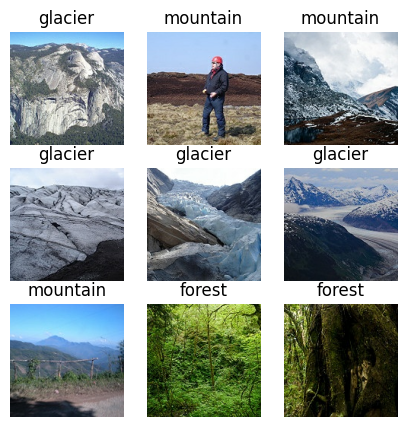

In [6]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = tf.argmax(labels[i]).numpy()
        plt.title(train_ds.class_names[label])
        plt.axis("off")

# Labeling

- This dataset needed some pre-processing.
- The images were generally labeled, since they were in categorized folders. However, for training it is necessary that each image is associated with its label, so each of the training and test images was labeled.
- The validation images could not be processed in this way because they were not categorized.

With this objective, the *'def labeling'* function was created, which also transforms the text labels to numeric labels and converts the lists in which the images and labels had been stored, into numpy arrays of type (float32) and type (int32).

This is because working with this type of data reduces the amount of storage memory, improves model performance, and because Keras needs its input data to be of this type.

Also to reduce the amount of the images size, we resized all the images with (150x150) in labeling to normalize after concludes the labels of each image.

In [7]:
# Create a dictionary to change text labels into int numerical labels (Ordered alphabetically)
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}

print(class_labels)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [8]:
# Resize of images
IMAGE_SIZE = (150, 150)

# def for labeling 
def labeling(folder_path, images, labels):
    # loop through all subfolders in the folder_path
    for label in os.listdir(folder_path):
        # get the path to the subfolder
        label_path = os.path.join(folder_path, label)

        # convert label text to label number
        label_number = class_labels[label]

        # loop through all images in subfolder
        for file_name in os.listdir(label_path):
            # upload image using Pillow
            image = Image.open(os.path.join(label_path, file_name))

            # resize image to desired size
            image = image.resize(IMAGE_SIZE)

            # convert the image to a Numpy array  
            image = np.array(image)

            # add image to testing_image list
            images.append(image)

            # add image label to testing_label list
            labels.append(label_number)
    # convert the images and labels list to numpy array
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    return images, labels

# Data Visualization

In this section you can see the results of the labeling.
An image of the training set is plotted and its label is printed, both are consistent.

In [9]:
# Training labeling
# list to store the images and their labels
training_images = []
training_labels = []
x_train, y_train = labeling(trainpath, training_images, training_labels)

# Testing labeling
# list to store the images and their labels
testing_images = []
testing_labels = []
x_test, y_test = labeling(testpath, testing_images, testing_labels)

label: 3, name: mountain


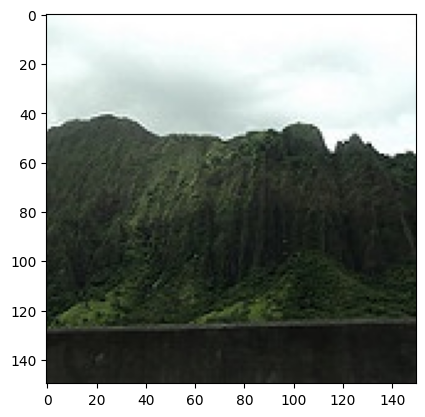

In [10]:
plt.imshow(training_images[5])
print(f'label: {training_labels[5]}, name: {class_names[training_labels[5]]}')

# Data preparation
- This part of the code has to be mean with hot-encodes, normalization, and splits of the data.

In the first part, we find the number of unique classes in the training tag set and then converts the categorical tags into a one-hot encoding representation for the training and test tag sets.

In [11]:
# Find the unique numbers from the train labels
num_clases = len(np.unique(y_train))

# Change the labels from categorical to one-hot encoding
y_train = to_categorical(y_train, num_clases)
y_test = to_categorical(y_test, num_clases)

In [12]:
# Visualize y_train after one hot encoding
y_train[0]

array([0., 0., 0., 1., 0., 0.], dtype=float32)

### Normalization

Second Part, the train and test images are normalized to make sure that all images have comparable pixel values and are in a manageable range.

This helps to improve the accuracy of the model and to reduce the variance of the input data.
The normalization being used here is known as **"Z-score normalization"** or **"standard normalization"**.

The mean and standard deviation of the training data are calculated and then used to scale both the training and test data, the formula used is: **(x - mean) / standard deviation**


This normalization centers the data at zero and scales the units to have a variance of one. The constant 1e-7 is added to the denominator to avoid a possible division by zero in case the standard deviation is very small.

In [13]:
# Using Z-score normalization to converge faster and improve accuracy
mean = np.mean(x_train)
std = np.std(x_train)


x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)

Finally, 10 percent of the **train set** is separated for validation since the set destined for validation was not labeled.

We chose to do the validation in this way (training by sending the train data and validation) to save time, make better use of the data, detect overfitting problems early and optimize the overall performance of the model.

In [14]:
# Split train and test
x_train, x_valid , y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=13)

In [15]:
print('train splitted:', x_train.shape[0])
print('val:', x_valid.shape[0])
print('test:', x_test.shape[0])

train splitted: 12630
val: 1404
test: 3000


# Building our Convnet Model

Convnet architecture:

Having the input images ready, these images go through a convolution network that extracts features (edges, textures, etc.) at first in a very superficial way and then, as it goes deeper into the network, much more complex features are extracted.

These convolution layers are linked to a maxpooling layer that reduces complexity by limiting the length and width of the images. And so layer after layer of stacked convolutions with maxpooling will give us back an image that is smaller and smaller but deeper in its meaning and information.

Next, a layer called Flatten is applied to flat the image input.


### General parameters:

**Kernel (filters)**:

We know that images are understood as arrays of pixels.

The kernel is also a matrix (but smaller) that moves from the upper left corner to the lower right corner of the image, going step by step until it completes the entire image by doing a little mathematical operation called convolution. And in this tour, a mathematical multiplication operation is executed that obtains the data and patterns for each row and column of the image.

The result of this convolution results in a new image with certain features highlighted. Thus, the objective of the filters is to detect features of the input images.


In our model we started using 32 filters in the first layer that were later increased in the following layers.


**Padding:**

It is a margin that is added to the image so that when performing the convolution operation the resulting image does not reduce its size. 'same' is used so that it does not alter the characteristics of the original images.
In our model we use padding = 'same'.


**Maxpooling:**

Reduces the size of the images resulting from the convolution thanks to a kernel that highlights only the most relevant features of the image.


### Parameters of the optimized models:

**Regularizers:**

We use the L2 regularization (which controls the magnitude of the weights)

kernel_regularizer=regularizers.l2(w_regularizer) is used to apply L2 regularization to the weights of a convolutional layer on a CNN. It helps to avoid overfitting and improve the generalizability of the model by penalizing large weights.


**Batch normalization:**

It is a normalization within the hidden layers, throught the training, since the weights vary constantly, these values can be standardized within the network. This facilitates gradient descent and works in batches. The result is standardized data even within the network training.


Which brings the resulting tensor to one dimension. And having only one dimension, the classification is done by stacking dense layers as it was done in typical neural networks.


In [16]:
filter_batch = 32
w_regulatizer = 1e-4

In [17]:
model = Sequential()
## conv 1
model.add(Conv2D(filter_batch, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

## conv 2
model.add(Conv2D(filter_batch, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

## conv 3
model.add(Conv2D(2*filter_batch, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

## conv 4
model.add(Conv2D(2*filter_batch, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

## conv 5
model.add(Conv2D(4*filter_batch, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())


## conv 6
model.add(Conv2D(4*filter_batch, (3,3), padding='same', kernel_regularizer=regularizers.l2(w_regulatizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

## Clasificacion - Flatten

model.add(Flatten())
model.add(Dense(num_clases,activation='softmax'))

# summary of the created convnet
#model.summary()

This is the summary of our first Convnet created plotted:

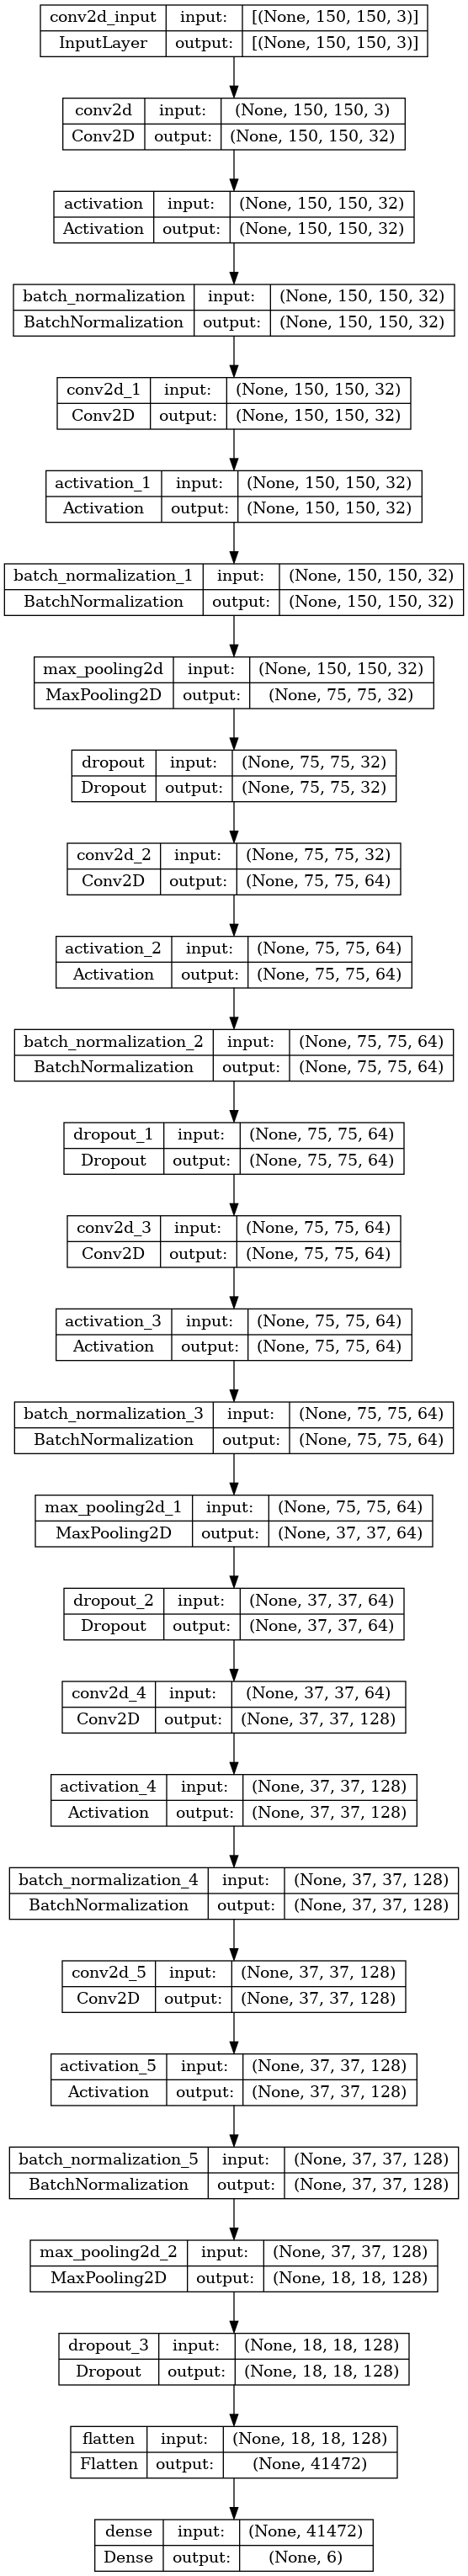

In [18]:
plot_model_file = 'first_model.png'
plot_model(model, to_file=plot_model_file, show_shapes=True)

As we can observe from the summary of our model, our first Convnet utilizes images that have already been resized to 150x150 and with each convolutional layer that passes, the size of the image is reduced by half, starting from the original size of 150 pixels and reaching 18 pixels as its limit.

With that we can see the importance to understand the extent to which size can be reduced because if we exceed too many small pixels like 2 or 1 as the minimum resize, the prediction accuracy could be bad.

### Data Augmentation

By using the ImageDataGenerator its parameters, we generate augmented images on the fly during the training.

These augmented images can then be used to train our saved model, enhancing and helping to generalize improve performance on unseen images.

In [19]:
## Data augmentation
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

# Compiling our first model
Using Adam optimizer and categorical_crossentropy lost function

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

**Callbacks:** early stopping and checkpoints

Early Stopping: 
When a neural network has stopped optimizing the accuracy or the metric that we put in 'monitor', if this metric does not rise, this can decide to end the training when the network begins to diverge.

Checkpoint: 
With this we can fully execute the training network throughout the epochs that we defined but in this file the weights of the neural network that had a better accuracy are saved. This ensures that the model is always the best.

In [21]:
checkpoint_model_name = 'my_first_model.hdf5'
checkpoint = ModelCheckpoint(checkpoint_model_name, verbose=1, save_best_only=True, monitor = 'val_accuracy')

In [22]:
BATCH_SIZE = 128
EPOCHS = 40

In [23]:
history_first_model = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
          callbacks=[checkpoint],
          steps_per_epoch=x_train.shape[0] // BATCH_SIZE, 
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_valid, y_valid))

Epoch 1/40


2023-05-17 19:21:40.473116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 [==============================] - ETA: 0s - loss: 4.1017 - accuracy: 0.4805
Epoch 1: val_accuracy improved from -inf to 0.18875, saving model to my_first_model.hdf5
98/98 [==============================] - 102s 863ms/step - loss: 4.1017 - accuracy: 0.4805 - val_loss: 10.8274 - val_accuracy: 0.1887
Epoch 2/40
98/98 [==============================] - ETA: 0s - loss: 2.2411 - accuracy: 0.5522
Epoch 2: val_accuracy improved from 0.18875 to 0.24430, saving model to my_first_model.hdf5
98/98 [==============================] - 80s 815ms/step - loss: 2.2411 - accuracy: 0.5522 - val_loss: 4.5645 - val_accuracy: 0.2443
Epoch 3/40
98/98 [==============================] - ETA: 0s - loss: 1.9407 - accuracy: 0.5925
Epoch 3: val_accuracy did not improve from 0.24430
98/98 [==============================] - 79s 805ms/step - loss: 1.9407 - accuracy: 0.5925 - val_loss: 5.2002 - val_accuracy: 0.2016
Epoch 4/40
98/98 [==============================] - ETA: 0s - loss: 1.6309 - accuracy: 0.6141
Epoch

In [83]:
# Defining accuracy and loss plot funtion
def plot_loss_accuracy(hist, save_image_filename, len_epochs):
    epochs = len_epochs
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'r--', label='Training Accuracy')
    plt.plot(epochs_range, val_acc,'b-' , label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'r--', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'b-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(save_image_filename) 
plt.show()

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-05-17 20:50:38        10563
variables.h5                                   2023-05-17 20:50:38      6538368
metadata.json                                  2023-05-17 20:50:38           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......activation_4
.........vars
......activation_5
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
...

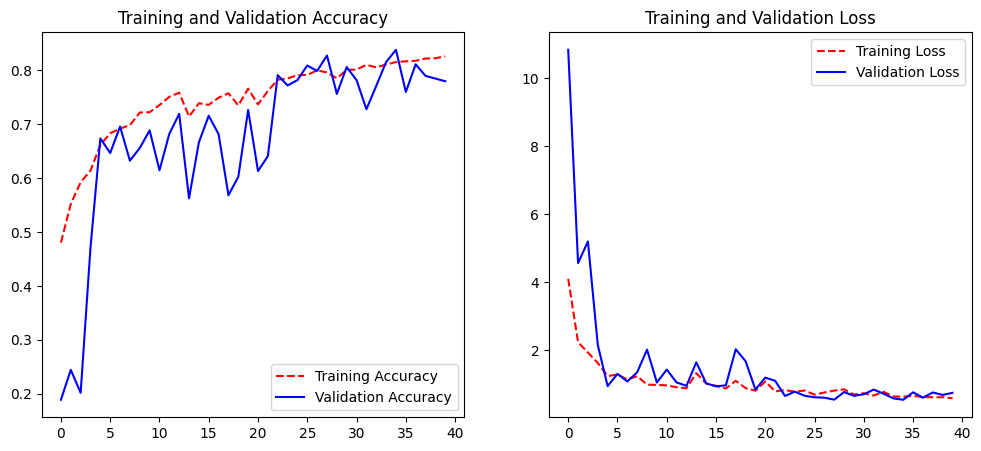

In [67]:
# Saving history of our first model fit
save_first_history_model_file = 'history_first_model.pkl'
save_pickle(history_first_model, save_first_history_model_file)

# Saving our first model
save_first_model_file = 'first-model-40-epochs.pkl'
save_pickle(model, save_first_model_file)


# Loading our first model with history plot
saved_history_first_model = load_pickle('/kaggle/working/history_first_model.pkl')
# call the function to plot the curves
plot_loss_accuracy(saved_history_first_model, 'loss_accuracy_40_saved.png', EPOCHS)

# Loading our first model with history plot
saved_first_model = load_pickle('/kaggle/working/first-model-40-epochs.pkl')

# Visualizing intermediate Activations

##### Quoting François Chollet in his book "DEEP LEARNING with Python"

Intermediate activations are "useful for understanding how successive Convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters."

Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

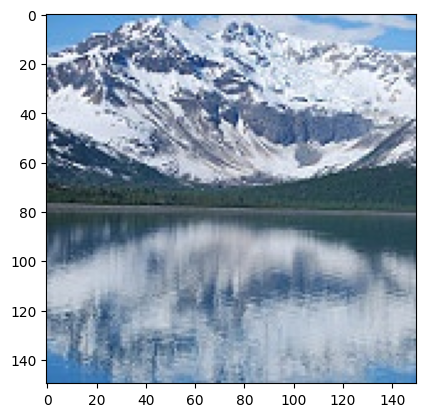

(1, 150, 150, 3)


In [86]:
img_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/glacier/20253.jpg'
img = image.load_img(img_path, target_size=IMAGE_SIZE)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

### Predicting images

With our first model trained and stored, we can load a simple unseen image from our test set and see how it is classified:

In [81]:
# predicting images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
#classes = saved_first_model.predict_classes(images, batch_size=10)
predict_x = saved_first_model.predict(images)
classes_x = np.argmax(predict_x, axis=1)

print("Predicted class is:", classes_x)
print("Predicted class is:", class_names[classes_x[0]])

1/1 [==============================] - 0s 25ms/step
Predicted class is: [1]
Predicted class is: forest


### Instantiating a model from an input tensor and a list of output tensors

In [71]:
# Extracts the outputs of the top 12 layers
layer_outputs = [layer.output for layer in saved_first_model.layers[:12]]
# Creates a model that will return these outputs, given the model input
activation_model = Model(inputs=saved_first_model.input, outputs=layer_outputs)

In [72]:
# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 231ms/step


In [73]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 150, 150, 32)


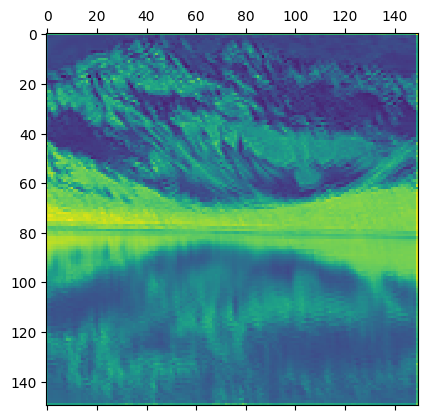

In [74]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

### Visualizing every channel in every intermediate activation

/tmp/ipykernel_31/1475786805.py:16: RuntimeWarning: invalid value encountered in subtract
  channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable


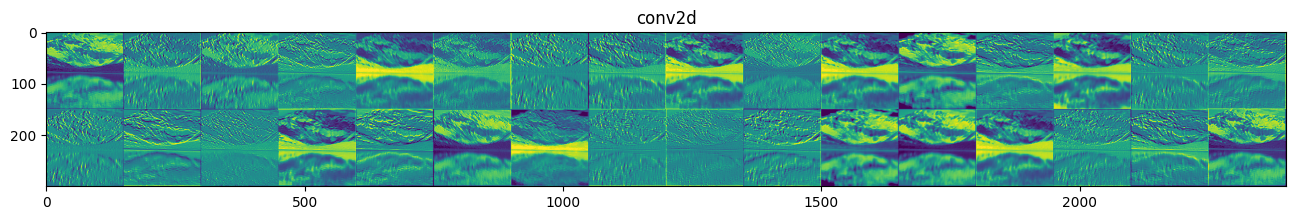

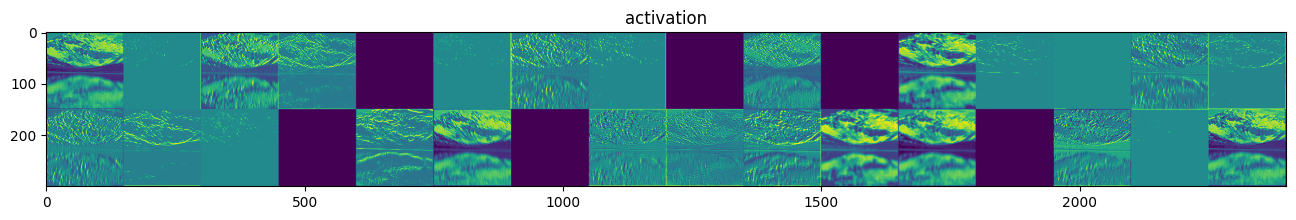

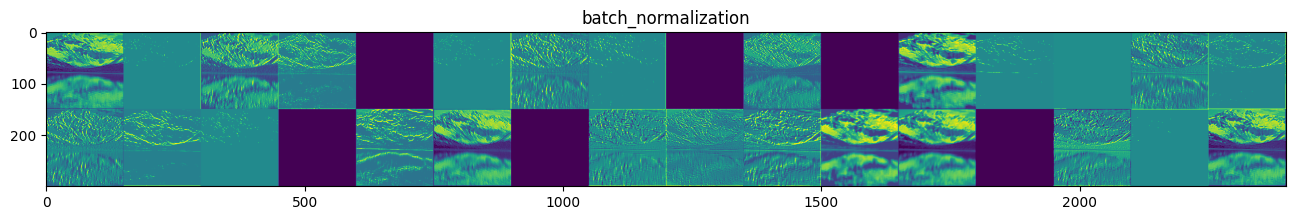

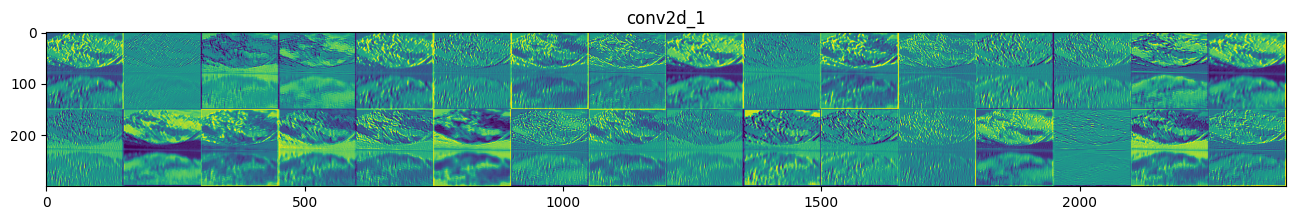

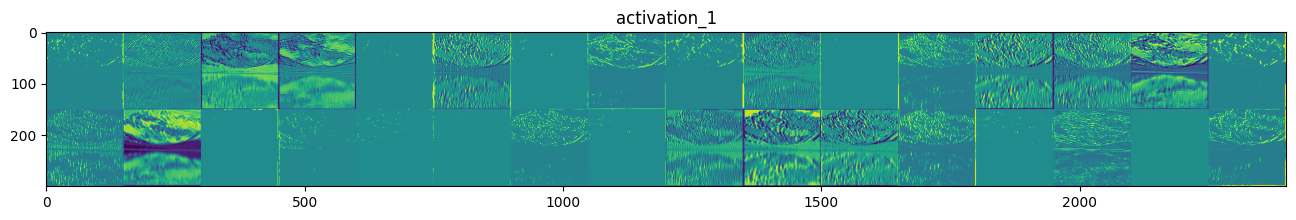

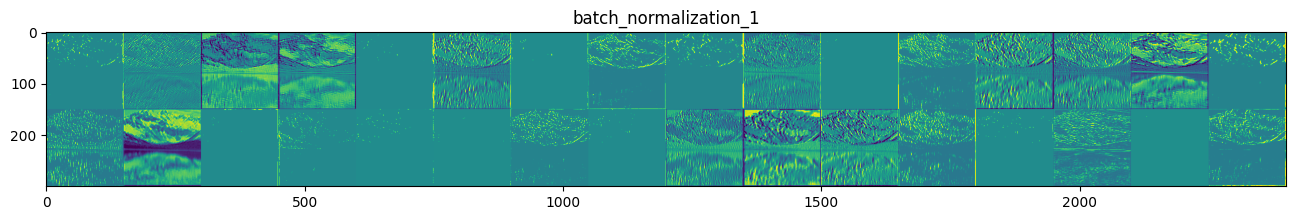

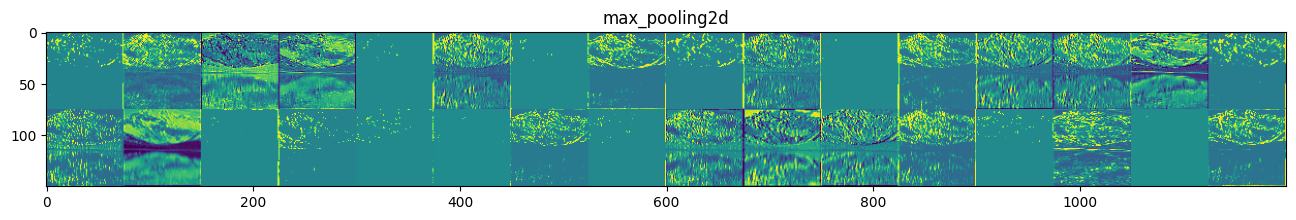

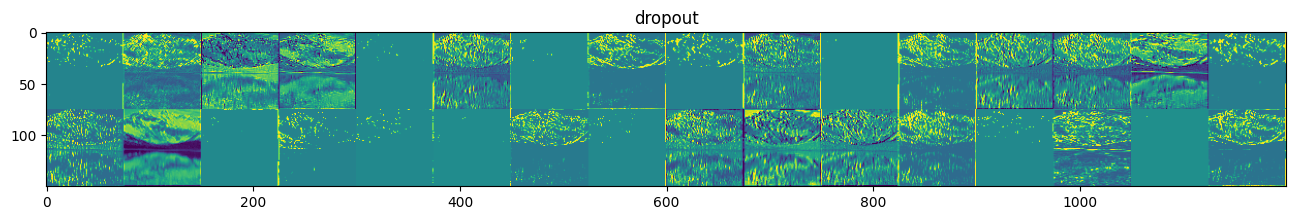

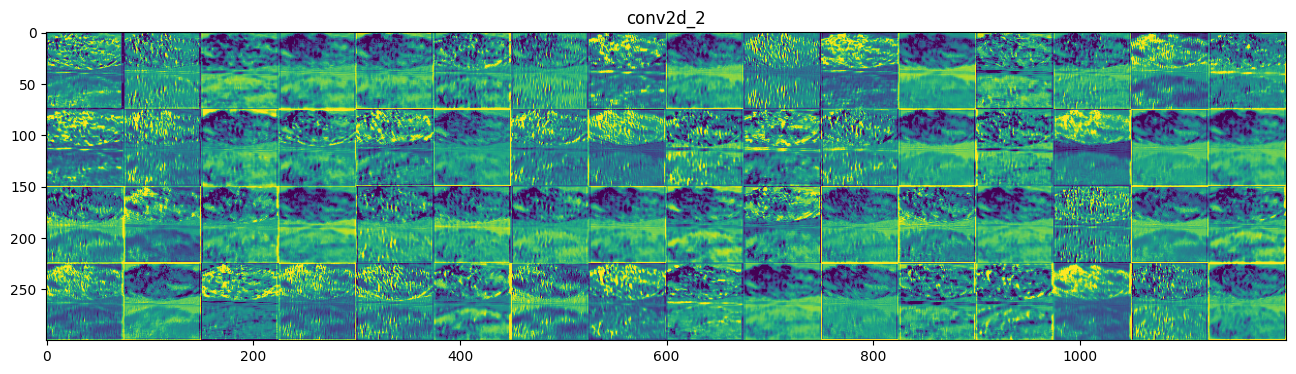

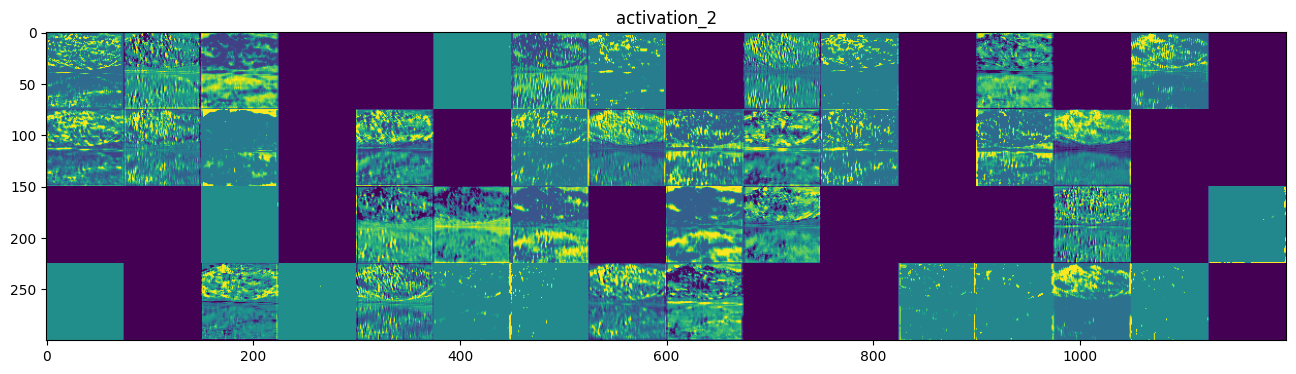

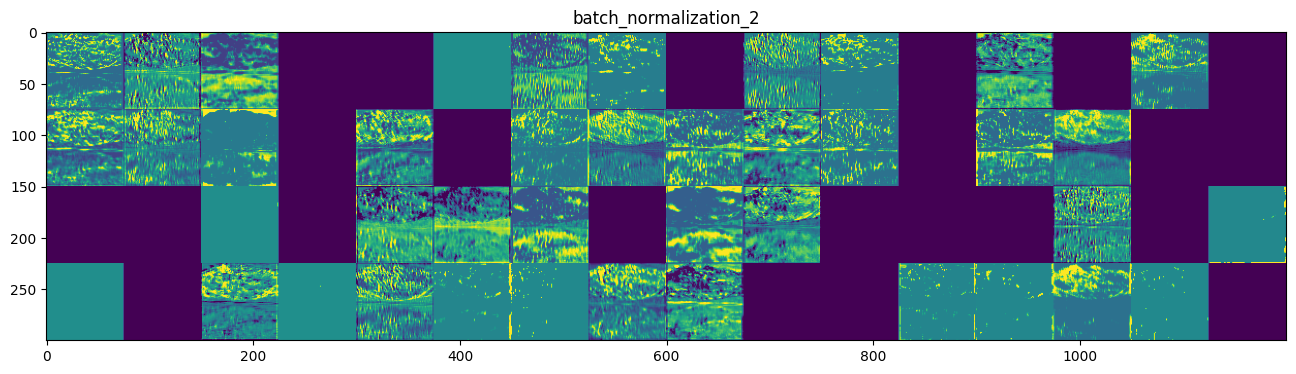

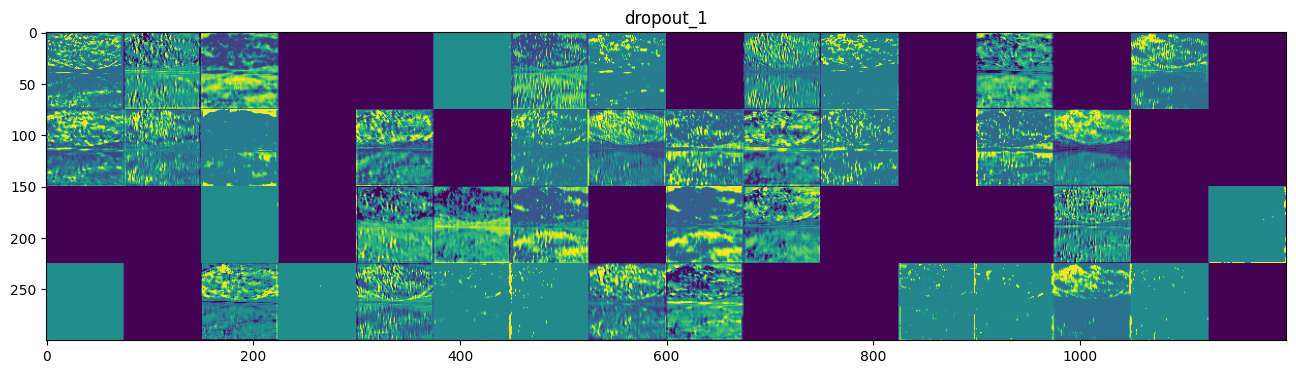

In [77]:
layer_names = []
for layer in saved_first_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

The first layer of the model shows that the image doesn't change much beacuse the size of 150x10 stands on it and it retains al the information about the image in one piece.

As we go deeper in the layers, we can see that the activation of each layer decreases in size with every layer that passes, they are less visually and interpretable, loosing some information about the image but mantaining it shape.

On the last layers we can see some **purple** fields, because of the compelxity of the cnn model the images are not shown in this fields and there is non an activation at all on it.